In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Misc
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

sns.set(rc={"figure.figsize": (12, 4)})

## First glance

In [2]:
df = pd.read_csv(os.path.join("..", "data", "stroke_data.csv"))

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


A few things come into mind when we see the first few rows of the data set:
- We are dealing with a classification problem (stroke True/False)
- ID seems unimportant for our cause, look for duplicates
- We can encode certain columns (Gender, Smoking_status, Work_type)
- Missing values are a thing (see bmi). Find a strategy to handle them
- Combination of continuous (Age, Glucose level, BMI) and categorical columns

In [4]:
# Convert residence type to bool
df["urban_residence"] = (df.Residence_type == "Urban")
df.drop("Residence_type", axis=1, inplace=True)

# Convert ever_married to bool
df.ever_married = (df.ever_married == "Yes")

# Convert heart_disease, hypertension
df.hypertension = df.hypertension.astype(bool)
df.heart_disease = df.heart_disease.astype(bool)

# Drop ID, its not needed
df.drop("id", axis=1, inplace=True)

In [5]:
df.describe()

,age,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,106.147677,28.893237,0.048728
std,22.612647,45.283560,7.854067,0.215320
min,0.080000,55.120000,10.300000,0.000000
25%,25.000000,77.245000,23.500000,0.000000
50%,45.000000,91.885000,28.100000,0.000000
75%,61.000000,114.090000,33.100000,0.000000
max,82.000000,271.740000,97.600000,1.000000


Checking for outliers will be important here. Avg_glucose_level as well as bmi seem to include a few (strong difference between 75th quantile and max; Compare max to mean + x*std, is x higher than 3?). In addition a BMI of 97 seems like a wrong measurement. We might want to quickly make a sanity check of how realistic certain values for BMI/Avg_glucose_level are.

In [6]:
df.describe(include="O")

,gender,work_type,smoking_status
count,5110,5110,5110
unique,3,5,4
top,Female,Private,never smoked
freq,2994,2925,1892


It looks good that the categorical columns do not seem to have too many classes. Let's look at them in detail:

In [7]:
for col in df.describe(include="O").columns:
    print(df[col].value_counts())
    print()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



For now I'm not sure what gender = "Other" means. For modelling purposes we'll discard this instance. In addition, we have to think about how to encode the smoking_status. "Unknown" is a problem here.

In [8]:
df.drop(df[df.gender == "Other"].index, inplace=True)

## Missing values

<AxesSubplot:>

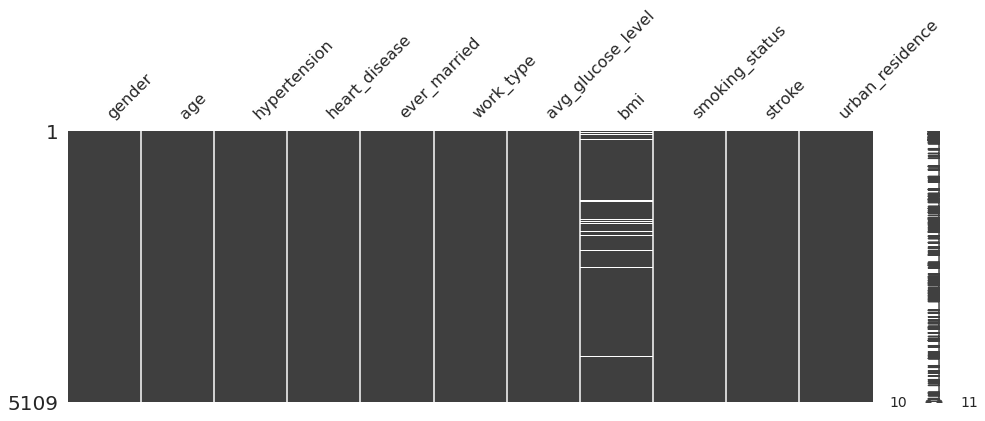

In [9]:
msno.matrix(df, figsize=(16, 5))

As already seen, we have missing values in the bmi column. The plot is somewhat wrong because we have "Unknown" entries in the smoking_status columns. However, we will not impute the smoking_status for now. Let's look at the bmi column and choose how to fix the missing values

In [10]:
df[df.bmi.isnull()].shape

(201, 11)

We have 201 instances where the BMI is missing. We will impute it with the mean of the gender of each instance. There are other ways to do this, for example sklearn has a series of more advanced techniques (e.g. KNNImputer). For the sake of simplicity we use an easy method.

In [11]:
df.loc[(df.gender == "Male") & (df.bmi.isnull()), "bmi"] = df[df.gender == "Male"].bmi.mean()
df.loc[(df.gender == "Female") & (df.bmi.isnull()), "bmi"] = df[df.gender == "Female"].bmi.mean()

## Check for extreme values

Extreme values are values which are likely to be measurement errors. They cannot be spotted as easily as NaNs, but are important to remove before using the data to train a model

### Underage smokers

Although some kids might start early, I'll rule out there are any smokers younger than 10 

In [12]:
df[df.age < 10].smoking_status.value_counts()

Unknown    472
Name: smoking_status, dtype: int64

In [13]:
df.loc[df.age < 10, "smoking_status"] = "never smoked"

### Underage marriages

In [14]:
df[df.age < 18].ever_married.sum()

0

This checks out, no underage marriages.

### Child labor

In [15]:
df[df.age < 14].work_type.value_counts()

children         630
Private           10
Never_worked       3
Self-employed      2
Name: work_type, dtype: int64

I could not find out where the data comes from. However, it seems odd that children younger than 14 work in the private sector, let alone are self-employed. I'll change them to children

In [16]:
df.loc[df.age < 14, "work_type"] = "children"

### BMI Extremes

BMI = weight in kg / (height in m) ** 2

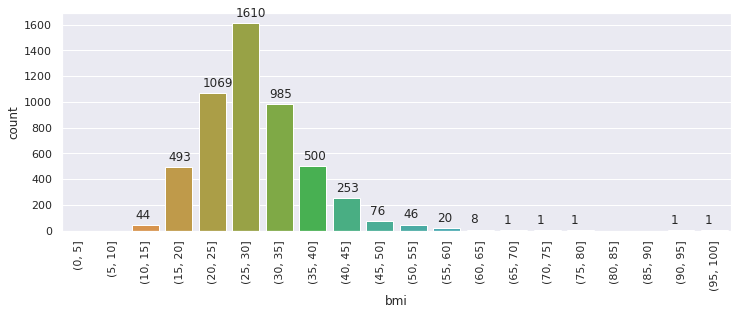

In [17]:
bmi_bins = pd.cut(df.bmi, bins=np.arange(0, 101, 5))

ax = sns.countplot(x=bmi_bins)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x()+0.1, p.get_height()+50), rotation=0)
    
plt.xticks(rotation=90)
plt.show()

According to medical information, a BMI of >40 is already severly obese. I'll discard samples with BMIs over 65 since they seem to be clear outliers.

In [18]:
df.drop(df[df.bmi > 65].index, inplace=True)

## Univariate Analysis

### Stroke

Description: Has this patient had a stroke?

0    4855
1     249
Name: stroke, dtype: int64


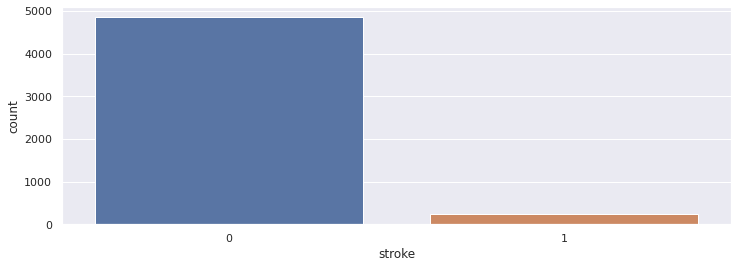

In [19]:
sns.countplot(x=df.stroke)

print(df.stroke.value_counts())

When we look at "stroke", the label we want to predict in this task, we notice the large class imbalance. The label "no stroke" is about 20 times more frequent than the label "stroke". This complicates classification tasks in several ways. One, the models that we'll train will have only few samples to learn "what a stroke looks like". Two, the chance of our model overfitting and just predicting "No stroke" all the time, is high.

We will have to keep the distribution of the "stroke" variable in mind for later. It will affect the choices of our models and metrics as well as motivate data augmentation techniques.

## Multivariate Analysis

### Age

Description: The age of the patient

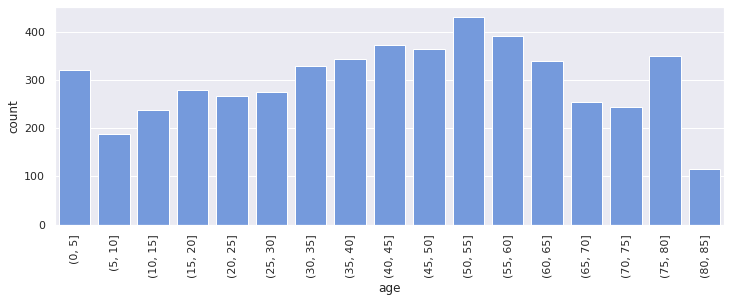

In [20]:
age_bins = pd.cut(df.age, bins=np.arange(0, 86, 5))

sns.countplot(x=age_bins, color="CornflowerBlue")
plt.xticks(rotation=90)

plt.show()

The age distribution is somewhat strange. Compared to https://en.wikipedia.org/wiki/Demographics_of_the_United_States#/media/File:USA2020dec1.png, we see an unusually high ammount of children in the age range of 0-5. In addition, the modus of our age distribution lies in the early 50s, not in the early 30s, like the overall US demographic. Also, we have a high ammount of patients in the range of 75 to 80. Given the advanced medical care in industrial countries it makes sense to have a large population in this age range.

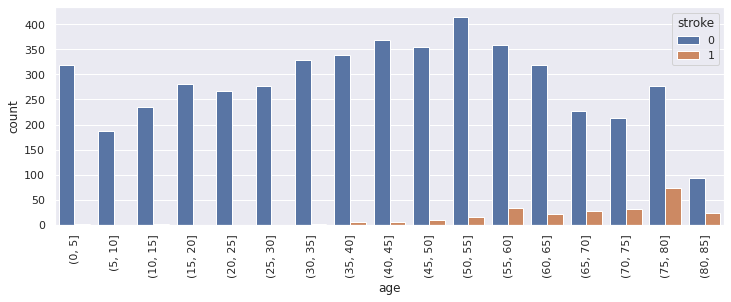

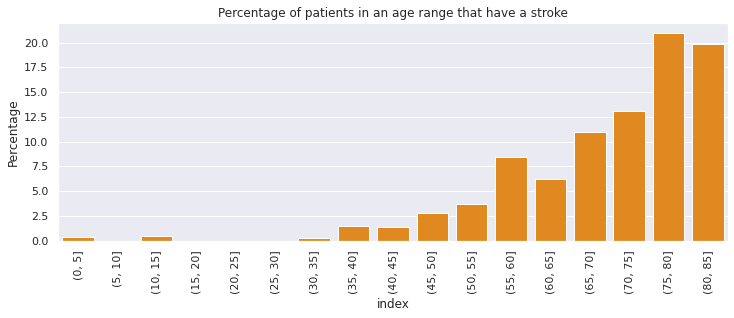

In [21]:
sns.countplot(x=age_bins, hue=df.stroke)
plt.xticks(rotation=90)

plt.show()

stroke_age_counts = pd.cut(df[df.stroke == 1].age, bins=np.arange(0, 86, 5)).value_counts() 
age_counts = pd.cut(df.age, bins=np.arange(0, 86, 5)).value_counts()

plot_df = (100 * stroke_age_counts / age_counts).to_frame().reset_index()

sns.barplot(data=plot_df, x="index", y="age", color="DarkOrange")
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.title("Percentage of patients in an age range that have a stroke")
plt.show()

As one would expect, strokes are a problem that arises with advanced age. We can see an increase in the number of strokes from the age of 35 onwards. The risk of a stroke is especially critical from the age of 75+. In these age ranges we observe 20% of the patients having strokes.

### Hypertension

Description: This indicates if the patient has high blood pressure. Medical sources indicate that there is a strong correlation to strokes

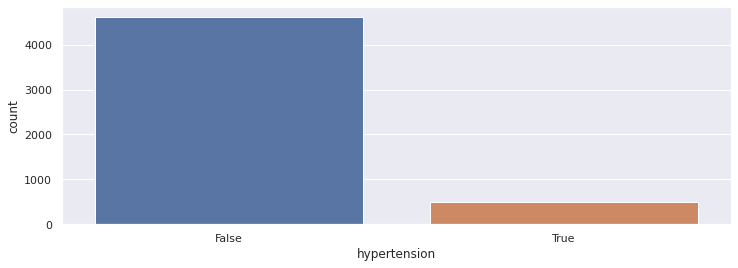

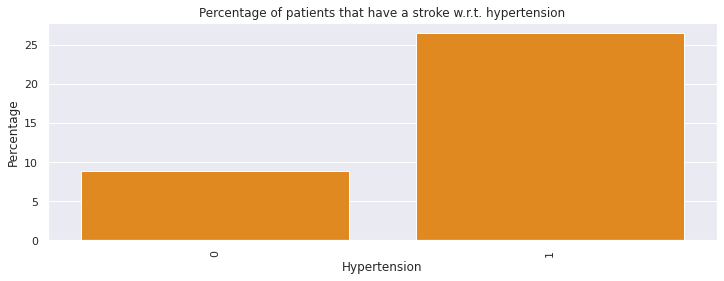

In [22]:
# Overall comparisson
sns.countplot(x=df.hypertension)
plt.show()

# Stroke patients comparisson
stroke_hyp_counts = df[df.hypertension].stroke.value_counts()
non_stroke_counts = df.stroke.value_counts()

plot_df = (100 * stroke_hyp_counts / non_stroke_counts).to_frame().reset_index()

sns.barplot(data=plot_df, x="index", y="stroke", color="DarkOrange")
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.xlabel("Hypertension")
plt.title("Percentage of patients that have a stroke w.r.t. hypertension")
plt.show()

We see the overall number of patients with a hypertension is small. However, so is the number of patients with a stroke.

This fits the medical research regarding hypertension: 25% of patients that have a stroke are suffering from hypertension. In contrast to that, only 8% of patients that have a stroke have none. This clearly indicates a correlation between the two.

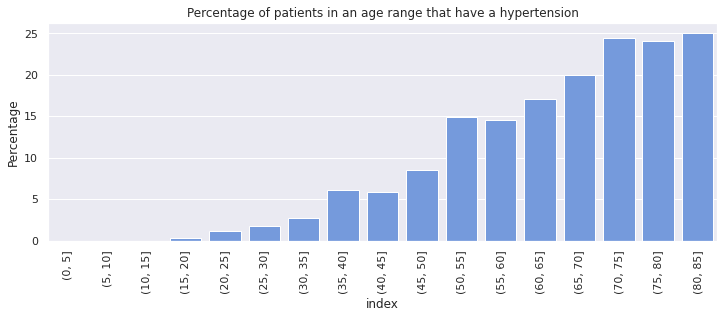

In [23]:
age_bins = pd.cut(df[df.hypertension].age, bins=np.arange(0, 86, 5))

hyp_age_counts = pd.cut(df[df.hypertension == 1].age, bins=np.arange(0, 86, 5)).value_counts() 
age_counts = pd.cut(df.age, bins=np.arange(0, 86, 5)).value_counts()

plot_df = (100 * hyp_age_counts / age_counts).to_frame().reset_index()

sns.barplot(data=plot_df, x="index", y="age", color="CornflowerBlue")
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.title("Percentage of patients in an age range that have a hypertension")
plt.show()

Regarding the age, this result is somewhat expected: Hypertensions rise with increasing age

### Heartt disease

Description: Has the patient some kind of heart disease apart from hypertension

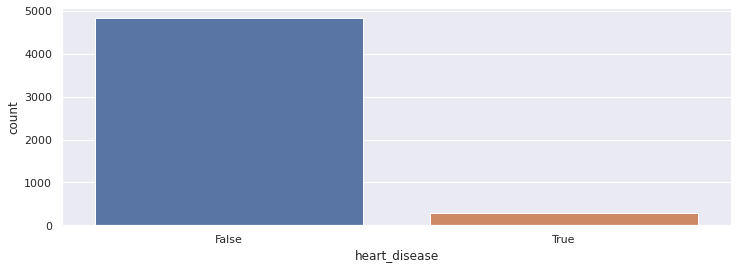

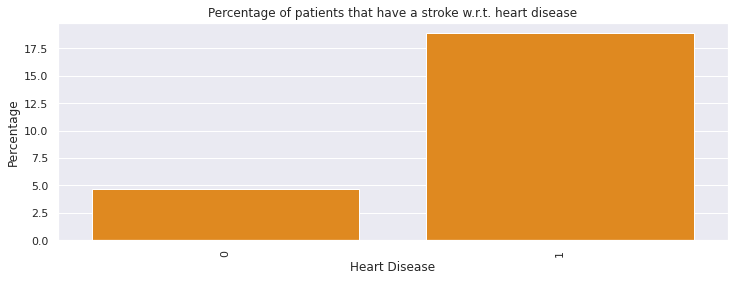

In [24]:
# Overall comparisson
sns.countplot(x=df.heart_disease)
plt.show()

# Stroke patients comparisson
stroke_hd_counts = df[df.heart_disease].stroke.value_counts()
non_stroke_counts = df.stroke.value_counts()

plot_df = (100 * stroke_hd_counts / non_stroke_counts).to_frame().reset_index()

sns.barplot(data=plot_df, x="index", y="stroke", color="DarkOrange")
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.xlabel("Heart Disease")
plt.title("Percentage of patients that have a stroke w.r.t. heart disease")
plt.show()

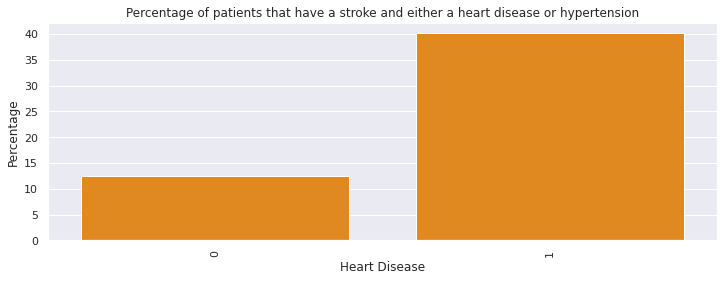

In [25]:
stroke_disease_counts = df[df.heart_disease | df.hypertension].stroke.value_counts()
non_stroke_counts = df.stroke.value_counts()

plot_df = (100 * stroke_disease_counts / non_stroke_counts).to_frame().reset_index()

sns.barplot(data=plot_df, x="index", y="stroke", color="DarkOrange")
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.xlabel("Heart Disease")
plt.title("Percentage of patients that have a stroke and either a heart disease or hypertension")
plt.show()

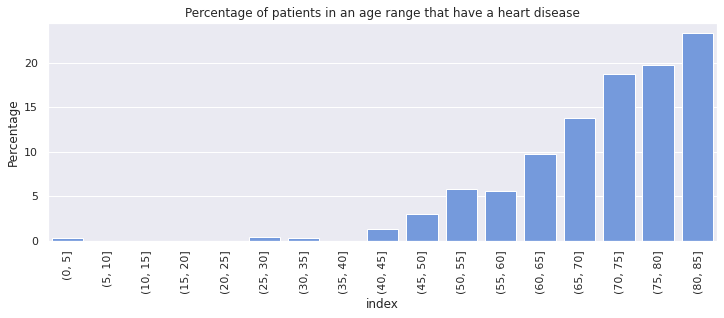

In [26]:
age_bins = pd.cut(df[df.heart_disease].age, bins=np.arange(0, 86, 5))

hd_age_counts = pd.cut(df[df.heart_disease == 1].age, bins=np.arange(0, 86, 5)).value_counts() 
age_counts = pd.cut(df.age, bins=np.arange(0, 86, 5)).value_counts()

plot_df = (100 * hd_age_counts / age_counts).to_frame().reset_index()

sns.barplot(data=plot_df, x="index", y="age", color="CornflowerBlue")
plt.xticks(rotation=90)
plt.ylabel("Percentage")
plt.title("Percentage of patients in an age range that have a heart disease")
plt.show()

Overall, heart disease seems to have a very similar effect on strokes as hypertension does. We observe a heart disease in ~18% of patients having a stroke, compared to 5% without it. In addition, we see that ~40% of patients with a stroke have some kind of heart problems (either heart disease or hypertension).

Regarding age, heart disease seem strongly correlated to increasing age.

# IDEAS

## SMOTE